<a href="https://colab.research.google.com/github/Victorlouisdg/simulators/blob/main/jax_implicit_cloth_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install meshzoo

In [2]:
import numpy as np
import jax.numpy as jnp
import jax.scipy.sparse
from jax import grad, jit, vmap, hessian
from jax import jacfwd, jacrev
from jax.lax import scan
from jax.ops import index
import meshzoo
from functools import partial
import plotly.graph_objs as go
import plotly.io as pio

pio.templates.default = "plotly_white" # also nice: "simple_white"
# pio.renderers.default = "colab"
# pio.renderers.default = "svg" # static plots for Github
pio.renderers.default = "notebook_connected" # interactive plots for NBViewer

# Mesh and state

## Getting the mesh from meshzoo
Baraff & Witkin simulate cloth as a 3D triangle mesh, but with a 2D rest state. 
This reflects the fact that clothes are made from pieces cut out of 2D sheets of fabric.

In [3]:
positions_uv, triangles = meshzoo.rectangle_tri(
    (0.0, 0.0),
    (1.0, 1.0),
    n=4,
    variant="zigzag",  # or "up", "down", "center"
)

positions_uv = jnp.array(positions_uv)
amount_of_triangles = triangles.shape[0]

print("There are", amount_of_triangles, "triangles in the mesh.")
print("The first triangle contains vertices:", triangles[0])

There are 32 triangles in the mesh.
The first triangle contains vertices: [0 1 6]


## Initializing the 3D positions

In [4]:
amount_of_vertices = positions_uv.shape[0]
print("There are", amount_of_vertices, "vertices in the mesh.")

There are 25 vertices in the mesh.


In [5]:
positions_z = np.zeros(amount_of_vertices)

positions = jnp.column_stack([positions_uv, positions_z])
velocities = jnp.zeros_like(positions)

system_size = 3 * amount_of_vertices

print("The positions array has shape", positions.shape, "and system size is", system_size, ".")

The positions array has shape (25, 3) and system size is 75 .


## Vizualizing the cloth with Plotly

In [6]:
def get_vertices_go(positions, color='deeppink'):
    x, y, z = positions.T
    vertices_go = go.Scatter3d(x=x, y=y, z=z,
                               mode='markers+text',
                               marker=dict(size=5, color=color),
                               text=[str(i) for i in range(len(positions))])
    return vertices_go

def get_mesh_go(positions, triangles, color='deepskyblue', opacity=1.0):
    x, y, z = positions.T
    i, j, k = triangles.T
    mesh_go = go.Mesh3d(x=x, y=y, z=z,
                        i=i, j=j, k=k,
                        color=color,
                        opacity=opacity,
                        hoverinfo='skip')
    return mesh_go

def make_fig(data, 
             xrange=[-0.6, 1.6], 
             yrange=[-1.1, 1.1], 
             zrange=[-2, 0.25], 
             eye=dict(x=-1.0, y=-1.0, z=1.0),
             center=None,
             up=None):
    fig = go.Figure(data=data)
    fig.update_layout(scene = dict(
        xaxis=dict(range=xrange, autorange=False),
        yaxis=dict(range=yrange, autorange=False),
        zaxis=dict(range=zrange, autorange=False),
        aspectmode='cube',
        camera = dict(eye=eye, center=center, up=up)
    ))

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) # tight layout
    return fig

data = [get_vertices_go(positions),
        get_mesh_go(positions, triangles)]

make_fig(data).show()

# Forces and Energy

## Deformation Gradient

In [7]:
def deformation_gradient(positions, positions_uv):
    uv0, uv1, uv2 = positions_uv
    delta_uv1 = uv1 - uv0
    delta_uv2 = uv2 - uv0 
    delta_u_matrix = jnp.column_stack((delta_uv1, delta_uv2))
    inverted_delta_u_matrix = jnp.linalg.inv(delta_u_matrix)

    x0, x1, x2 = positions
    delta_x1 = x1 - x0
    delta_x2 = x2 - x0
    delta_x_matrix = jnp.column_stack((delta_x1, delta_x2))

    # Equation (9) in Baraff-Witkin.
    w_uv = delta_x_matrix @ inverted_delta_u_matrix
    wu, wv = jnp.hsplit(w_uv, 2)
    return wu, wv

## Energy of a single triangle

In [8]:
triangle = jnp.array([[0, 1, 2]])
triangle_positions = jnp.array([[0.0, 0.0, 0.0],
                                [1.0, 0.0, 0.0],
                                [0.5, 0.5, 0.0]])

triangle_positions_uv = jnp.array([[0.0, 0.0], [1.0, 0.0], [0.5, 0.5]])
triangle_positions_new = triangle_positions.at[index[2, 1]].add(0.5)

In [9]:
def triangle_area(triangle_vertices):
    v0, v1, v2 = triangle_vertices
    return jnp.linalg.norm(jnp.cross(v1 - v0, v2 - v0)) / 2.0

In [10]:
def stretch_energy(positions, positions_uv, ku, kv):
    """
    Calculates the energy due to stretching of a single triangle.

    :param positions: The current 3D positions of the 3 vertices.
    :param positions_uv: The 2D rest positions of the 3 vertices.
    :param ku: The stretch stiffness in the U direction.
    :param kv: The stretch stiffness in the V direction.
    """
    wu, wv = deformation_gradient(positions, positions_uv)
    area_uv = triangle_area(positions_uv)

    Cu = jnp.linalg.norm(wu) - 1.0
    Cv = jnp.linalg.norm(wv) - 1.0

    Eu = 0.5 * area_uv * (Cu ** 2)
    Ev = 0.5 * area_uv * (Cv ** 2)

    E = ku * Eu + kv * Ev
    return E

In [11]:
triangle_forces = -1.0 * grad(stretch_energy)(triangle_positions_new, 
                                              triangle_positions_uv, 
                                              200.0, 200.0)
print(triangle_forces)

[[  -0.   50.   -0.]
 [  -0.   50.   -0.]
 [  -0. -100.   -0.]]


In [12]:
def get_cones_go(positions, directions,):
    x, y, z = positions.T
    u, v, w = directions.T
    cones_go = go.Cone(x=x, y=y, z=z,
                       u=u, v=v, w=w,
                       sizemode='scaled',
                       sizeref=0.1)
    return cones_go

data = [get_vertices_go(triangle_positions_new, color='green'),
        get_vertices_go(triangle_positions),
        get_mesh_go(triangle_positions_new, triangle, opacity=0.4, color='lightblue'),
        get_mesh_go(triangle_positions, triangle, opacity=0.4),
        get_cones_go(triangle_positions_new, triangle_forces)]

cx, cy, cz = triangle_positions[2]
make_fig(data, 
         xrange=[-0.4, 1.2],
         yrange=[-0.4, 1.2],
         zrange=[-0.5, 0.5],
         eye=dict(x=1.0, y=-0.1, z=1.0)).show()

## Total energy

In [13]:
def triangle_energy(positions, 
                    vertex_indices, 
                    k_stretch_u, 
                    k_stretch_v, 
                    positions_uv):
  uv0, uv1, uv2 = positions_uv[vertex_indices]
  x0, x1, x2 = positions[vertex_indices]
  energy = stretch_energy((x0, x1, x2), (uv0, uv1, uv2), k_stretch_u, k_stretch_v)
  return energy

In [14]:
def total_mesh_energy(positions_flat, triangle_energy_fn, triangles):
    positions = positions_flat.reshape(-1, 3)
    triangle_energy_vmap_fn = jit(partial(triangle_energy_fn, positions))
    energies = vmap(triangle_energy_vmap_fn)(triangles)
    total_energy = jnp.sum(energies)
    return -total_energy


triangle_energy_fn = partial(triangle_energy,
                             k_stretch_u=1000.0,
                             k_stretch_v=1000.0,
                             positions_uv=positions_uv)

total_mesh_energy(positions, triangle_energy_fn, triangles)

total_mesh_energy_ = partial(total_mesh_energy,
                             triangle_energy_fn=triangle_energy_fn,
                             triangles=triangles)

In [15]:
forces_fn = jit(grad(total_mesh_energy_))

# Gravity

In [16]:
m = 1.0 / amount_of_vertices
masses = jnp.array([m] * system_size)

standard_gravity = [0.0, 0.0, -9.81]
gravity_forces = masses * jnp.array(standard_gravity * amount_of_vertices)

# Time Integration

## Explicit Integration

In [17]:
dt_explicit = 0.0001

In [18]:
def simulate_step_explicit(carry,
                           unused_input,
                           forces_fn,
                           masses, 
                           pinned_vertices, 
                           dt):
    positions, velocities = state = carry

    f0 = forces_fn(positions.flatten())
    f0 = f0 + gravity_forces
    accelerations = f0 / masses
    accelerations = accelerations.reshape(-1, 3)


    accelerations = accelerations.at[pinned_vertices].set(0.0)

    velocities_new = velocities + accelerations * dt
    positions_new = positions + velocities * dt


    carry = state_new = positions_new, velocities_new
    output = positions_new
    return (carry, output)    

In [19]:
def simulate(step_function, initial_state, num_steps):
    outputs = scan(step_function, initial_state, jnp.arange(num_steps))[1]
    return outputs


pinned_vertices = jnp.array([0, 4])
simulate_step_explicit_jit = jit(partial(simulate_step_explicit, 
                                             forces_fn=forces_fn,
                                             masses=masses,
                                             pinned_vertices=pinned_vertices,
                                             dt=dt_explicit))


simulate_explicit = jit(partial(simulate, simulate_step_explicit_jit), 
                        static_argnames='num_steps')

initial_state = positions, velocities
history_explicit = simulate_explicit(initial_state, 50000)

In [20]:
def frame_data(positions, triangles):
    return [
       get_vertices_go(positions),
       get_mesh_go(positions, triangles)
    ]

def animate_cloth(history, triangles, dt, fps=30):

    fig = make_fig(frame_data(positions, triangles))

    fps_simulation = 1 / dt
    skip = np.floor(fps_simulation / fps).astype(np.int32)
    fps_adjusted = fps_simulation / skip
    print(f'fps was adjusted to: {fps_adjusted:.2f}')

    fig.update_layout(updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None, dict(frame=dict(redraw=True,fromcurrent=True, mode='immediate'))]
                                        )])])

    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000.0 / fps_adjusted

    indices = np.arange(0, len(history), skip)
    frames = [go.Frame(data=frame_data(history[i], triangles)) for i in indices]

    fig.update(frames=frames)
    fig.show()

animate_cloth(history_explicit, triangles, dt_explicit)

fps was adjusted to: 30.03


## Implicit Integration

In [21]:
dt_implicit = 0.01

In [22]:
force_derivatives_fn = jacfwd(forces_fn)
# or equivalently:
# energy_hessian_fn = hessian(total_mesh_energy)

In [23]:
def simulate_step_implicit(carry, 
                           unused_input,
                           forces_fn,
                           force_derivatives_fn,
                           M, S, z, dt): 
    positions, velocities = state = carry
    h = dt

    x0 = positions.flatten()
    v0 = velocities.flatten()

    f0 = forces_fn(x0)
    f0 = f0 + gravity_forces
    dfdx = force_derivatives_fn(x0)

    # Equation (16) in Baraff-Witkin.
    A = M - (h * h) * dfdx
    b = h * (f0 + h * (dfdx @ v0))

    # Prefiltering the system (see also: Dynamic Deformables section 10.1.1)
    I = np.identity(system_size)
    LHS = (S @ A @ S) + I - S
    c = b - A @ z
    rhs = S @ c

    LHS_func = lambda x : LHS @ x

    y = jax.scipy.sparse.linalg.cg(LHS_func, rhs)[0]

    x = y + z

    delta_v = x.reshape(-1, 3)

    velocities_new = velocities + delta_v
    positions_new  = positions + velocities_new * dt

    carry = state_new = positions_new, velocities_new
    output = positions_new
    return (carry, output)

In [24]:
M = jnp.diag(masses)
S = jnp.identity(system_size)

for i in pinned_vertices:
    S = S.at[index[3*i:3*i+3, 3*i:3*i+3]].set(0.0)

z = jnp.zeros(system_size)

In [25]:
simulate_step_implicit_jit = partial(simulate_step_implicit,
                                     forces_fn=forces_fn,
                                     force_derivatives_fn=force_derivatives_fn,
                                     M=M,
                                     S=S,
                                     z=z,
                                     dt=dt_implicit)

simulate_implicit = jit(partial(simulate, simulate_step_implicit_jit), 
                        static_argnames='num_steps')

initial_state = positions, velocities
history_implicit = simulate_implicit(initial_state, 500)

In [26]:
animate_cloth(history_implicit, triangles, dt_implicit)

fps was adjusted to: 33.33


### The need for sparse jacobians and hessians

(75, 75)


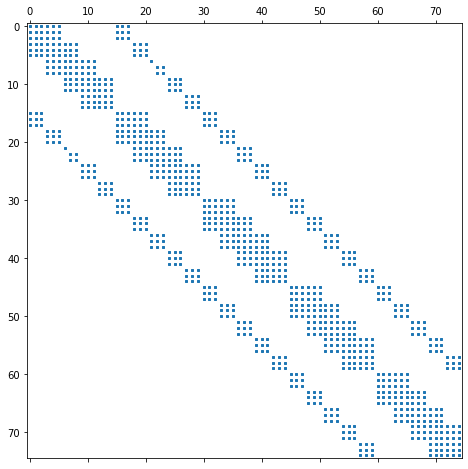

In [27]:
import matplotlib.pyplot as plt

dfdx = force_derivatives_fn(history_implicit[-1].flatten())
print(dfdx.shape)
plt.figure(figsize=(8,8))
plt.spy(dfdx, markersize=2.8);

Shoutouts:

Eric Jang Ray Tracing in JAX

Dynamics Deformables course